Name: Holly Kular\
Date: 12-02-2024\
Email: hkular@ucsd.edu\
Description: use CEBRA to see change in stim representations over time

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colormaps
import cebra
import cebra.models
from cebra import CEBRA
import matplotlib.cm as cm

In [2]:
# which model do we want to explore
afc = 2
coh = 'hi'
mod = 0

In [3]:
# load RNN model and trials

if sys.platform.startswith('linux'):
        data_dir = f"/mnt/neurocube/local/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
else:
        data_dir = f"/Volumes/serenceslab/holly/RNN_Geo/data/rdk_70_30_{afc}afc/feedforward_only/{coh}_coh"
        
mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat') and not f.startswith('._')]# Get all the trained models (should be 40 .mat files)
model_path = os.path.join(data_dir, mat_files[mod]) 
model = loadmat(model_path)   
data_file = f"{data_dir}/Trials1000_model{model_path[-7:-4]}_neutral.npz"
data = np.load(data_file) #fr1 fr3 outs labs


In [6]:
# build CEBRA model

cebra_model = CEBRA(
model_architecture = "offset10-model",
batch_size = 512,
temperature = 1.13,
learning_rate = 3e-4,
max_iterations = 10000,
time_offsets = 10,
distance = "cosine",
output_dimension = 3,
conditional = "time",
device = "cuda_if_available",
verbose = True)


# temperature auto results in error

In [7]:
# Initialize the figure
fr = data['fr3']
labels = data['labs'].flatten() 
unique_labels = np.unique(labels)

embeds = np.zeros((250 , 3, len(unique_labels)))

for i, label in enumerate(unique_labels):
    # Filter trials for this label
    label_idx = labels == label
    fr_label = fr[label_idx]  # trials for this label, shape: trials x time x units

    # collapse across trials and time
    fr_col = fr_label.reshape((fr_label.shape[0]*fr_label.shape[1], fr_label.shape[2]))

    # Perform CEBRA
    cebra_model.fit(fr_col)
    cebra_all = cebra_model.transform(fr_col)
    reshaped_cebra_all = cebra_all.reshape((fr_label.shape[0], fr_label.shape[1], 3))
    embeds[:,:,i] = reshaped_cebra_all.mean(axis = 0)



pos: -0.7991 neg:  6.3839 total:  5.5848 temperature:  1.1300: 100%|█| 10000/100
pos: -0.8081 neg:  6.3721 total:  5.5640 temperature:  1.1300: 100%|█| 10000/100


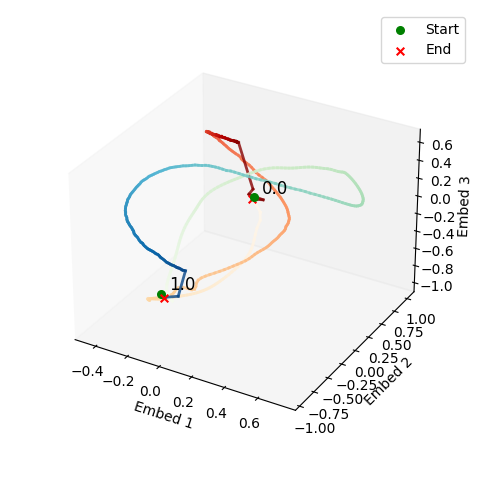

In [9]:
# Plot trajectories
# Initialize the figure
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, projection='3d') 
for i, label in enumerate(unique_labels):
    cmap = plt.get_cmap(['OrRd', 'GnBu', 'BuPu', 'BrBG', 'PuRd', 'BuGn'][i % 5])  # Cycle through colors
    norm = plt.Normalize(vmin=0, vmax=embeds.shape[0])
    colors = cmap(norm(np.arange(embeds.shape[0])))
    for j in range(embeds.shape[0] - 1):
        ax.plot(embeds[j:j+2, 0, i], embeds[j:j+2, 1,i], embeds[j:j+2, 2, i], 
                color=colors[j], alpha=0.8, linewidth=2)
    
    # Mark start and stop points
    ax.scatter(embeds[0, 0,i], embeds[0, 1,i], embeds[0, 2,i], color='green', marker='o', s=30, label="Start" if i == 0 else "")
    ax.text3D(embeds[0, 0, i]+.1, embeds[0, 1, i]+.1, embeds[0, 2, i]+.1, str(label), color='black', fontsize=12, ha='center', va='center') 
    ax.scatter(embeds[-1, 0,i], embeds[-1, 1,i], embeds[-1, 2,i], color='red', marker='x', s=30, label="End" if i == 0 else "")
# Hide grid lines
ax.grid(False)
ax.set_xlabel('Embed 1', rotation=150)
ax.set_ylabel('Embed 2')
ax.set_zlabel('Embed 3', rotation=60)
ax.set_box_aspect(None, zoom=0.85)
ax.legend()
plt.show()